The objective of this project is to develop a Predictive Model for ICU Admissions and a Patient Risk Classification System using synthetic patient data from Synthea. The system will analyze patient characteristics, clinical observations, and medical history to assign patients to one of three risk categories—Low, Medium, or High—based on their likelihood of requiring ICU care. By predicting which individuals are at high risk of ICU admission, the model will assist hospital administrators and healthcare providers in tracking patient trends, improving situational awareness, and supporting data-driven decision-making for resource planning and patient management. The system will serve as a prototype to help healthcare providers prioritize patient care, identifying those who may require closer monitoring or early intervention

In [2]:
import pandas as pd

patients = pd.read_csv('patients.csv')
encounters = pd.read_csv('encounters.csv')
conditions = pd.read_csv('conditions.csv')
observations = pd.read_csv('observations.csv')
medications = pd.read_csv('medications.csv')

print(patients.columns)
print(encounters.columns)
print(conditions.columns)
print(observations.columns)
print(medications.columns)

Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE',
       'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'INCOME'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'SYSTEM', 'CODE',
       'DESCRIPTION'],
      dtype='object')
Index(['DATE', 'PATIENT', 'ENCOUNTER', 'CATEGORY', 'CODE', 'DESCRIPTION',
       'VALUE', 'UNITS', 'TYPE'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'PAYER', 'ENCOUNTER', 'CODE', 'DESCRIPTION',
       'BASE_COST', 'PAYER_COVERAGE', 'DISPENSES', 'TOTALCOST', 

In [4]:
print(patients.shape)
print(encounters.shape)
print(conditions.shape)
print(observations.shape)
print(medications.shape)

(108, 28)
(6610, 15)
(3513, 7)
(65975, 9)
(5116, 13)


As we observed in the columns of the above datasets we have patient in every dataset except in patients.csv, but the column name Id represents the same thing so we are changing the name of Id into PATIENT for the analysis

In [7]:
import pandas as pd

patients.rename(columns={'Id': 'PATIENT'}, inplace=True)
# Check the updated columns
print(patients.columns)

Index(['PATIENT', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT',
       'PREFIX', 'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL',
       'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE',
       'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'INCOME'],
      dtype='object')


Before Merging the datasets as a single dataset we can first check the referral integrity of the data and then merge the datasets as a single dataset with the only required columns

In [16]:
import pandas as pd

# List of datasets to check for referential integrity
datasets = [encounters, conditions, observations, medications]

# Print the columns of the patients dataset for debugging
print("Columns in patients dataset:", patients.columns.tolist())

# Function to check referential integrity
def check_referential_integrity(patients_df, dataset_df, dataset_name):
    # Print the columns of the datasets for debugging
    print(f"Columns in {dataset_name} dataset: {dataset_df.columns.tolist()}")
    
    # Ensure the 'PATIENT' column exists
    if 'PATIENT' not in dataset_df.columns:
        print(f"Error: 'PATIENT' column not found in {dataset_name} dataset.")
        return
    
    # Get the set of unique patient IDs in both the patients dataset and the current dataset
    patients_set = set(patients_df['PATIENT'])
    dataset_set = set(dataset_df['PATIENT'])
    
    # Find unmatched patient IDs in the dataset
    unmatched_patients = dataset_set - patients_set
    
    if unmatched_patients:
        print(f"Warning: Found {len(unmatched_patients)} unmatched patient(s) in {dataset_name} dataset.")
        print(f"Unmatched patients: {unmatched_patients}")
    else:
        print(f"All patients in the {dataset_name} dataset are valid (referential integrity is maintained).")

# Check referential integrity for each dataset
for dataset, name in zip(datasets, ['encounters', 'conditions', 'observations', 'medications']):
    check_referential_integrity(patients, dataset, name)


Columns in patients dataset: ['PATIENT', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'INCOME', 'AGE']
Columns in encounters dataset: ['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER', 'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST', 'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION']
All patients in the encounters dataset are valid (referential integrity is maintained).
Columns in conditions dataset: ['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'SYSTEM', 'CODE', 'DESCRIPTION']
All patients in the conditions dataset are valid (referential integrity is maintained).
Columns in observations dataset: ['DATE', 'PATIENT', 'ENCOUNTER', 'CATEGORY', 'CODE', 'DESCRIPTION', 'VALUE', 'UNITS', 'TYPE']
All patient

As we see in the above steps there is no mis match in the referential integrity as it is maintained we can proceed to the next steps to merging the datasets if we have all enough data for data analysis

For calculation of risk score we are also taking age as an factor. but we dont have age in our dataset. so we are calculating the age from the Date of birth given in the dataset. we are calculating this using the present date as the patient is still alive. The process to do this as below code. 

In [20]:
import pandas as pd
from datetime import datetime

# Ensure that 'BIRTHDATE' is in datetime format
patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'])

# Calculate the current date (or the date of the last visit)
current_date = datetime.now()

# Calculate the age by subtracting the birth date from the current date and converting it into years
patients['AGE'] = (current_date - patients['BIRTHDATE']).dt.days // 365

# Display the updated DataFrame with the patient ID and age
print(patients[['PATIENT', 'BIRTHDATE', 'AGE']].head())

                                PATIENT  BIRTHDATE  AGE
0  782c4f6e-4b08-ffba-af94-d6c1677ea363 1984-12-12   40
1  420f99e2-712f-6890-43b9-4e44d7d7d003 1994-02-08   31
2  3e953a04-3f6c-5d5f-4e6b-19ea23e75b6c 1974-11-26   50
3  283414fa-9712-c6b3-81cd-394a795629b6 1995-08-05   29
4  503ffe92-a8d8-3d20-21ab-f66fafccb467 1969-08-15   55


We removed the patients with the death date from the analysis as most part of our problem statement is we are focusing on the ICU admission prediction based on the risk score. So we removing the patients with the death date for avoiding the inaccurate outputs in the analysis.

In [23]:
print(patients.shape)
print(encounters.shape)
print(conditions.shape)
print(observations.shape)
print(medications.shape)

(108, 29)
(6610, 15)
(3513, 7)
(65975, 9)
(5116, 13)


In [25]:
import pandas as pd

# Step 1: Identify and remove patients with a death date
patients_with_death_date = patients[patients['DEATHDATE'].notna()]
patients = patients[patients['DEATHDATE'].isna()]

In [27]:
print(patients.shape)

(100, 29)


In [29]:
# Step 2: Remove the patients with death date from all other datasets based on the 'PATIENT' column
encounters = encounters[encounters['PATIENT'].isin(patients['PATIENT'])]
conditions = conditions[conditions['PATIENT'].isin(patients['PATIENT'])]
observations = observations[observations['PATIENT'].isin(patients['PATIENT'])]
medications = medications[medications['PATIENT'].isin(patients['PATIENT'])]

In [31]:
print(patients.shape)
print(encounters.shape)
print(conditions.shape)
print(observations.shape)
print(medications.shape)

(100, 29)
(5652, 15)
(3054, 7)
(53549, 9)
(3877, 13)


In [33]:
print(patients.columns)
print(encounters.columns)
print(conditions.columns)
print(observations.columns)
print(medications.columns)

Index(['PATIENT', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT',
       'PREFIX', 'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL',
       'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE',
       'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'INCOME', 'AGE'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'SYSTEM', 'CODE',
       'DESCRIPTION'],
      dtype='object')
Index(['DATE', 'PATIENT', 'ENCOUNTER', 'CATEGORY', 'CODE', 'DESCRIPTION',
       'VALUE', 'UNITS', 'TYPE'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'PAYER', 'ENCOUNTER', 'CODE', 'DESCRIPTION',
       'BASE_COST', 'PAYER_COVERAGE', 'DISPENSES', '

So we have all the required columns to move this forward. So in the steps below before proceeding to the EDA we can keep only the required columns for our ptroblem statement so it is easy to find out and handle the missing values and the outliers

In [38]:
import pandas as pd

# Step 1: Define strictly required columns for ICU risk classification
required_columns_patients = ['PATIENT', 'AGE']  # Only essential demographic info
required_columns_encounters = ['PATIENT', 'ENCOUNTERCLASS', 'TOTAL_CLAIM_COST', 'BASE_ENCOUNTER_COST']  # ICU admission predictors
required_columns_conditions = ['PATIENT', 'CODE']  # Comorbidities (disease codes)
required_columns_observations = ['PATIENT', 'CODE', 'VALUE', 'UNITS']  # Vital signs & lab results
required_columns_medications = ['PATIENT', 'CODE', 'TOTALCOST']  # Medication history impact

# Step 2: Filter datasets to retain only essential columns
patients = patients[required_columns_patients]
encounters = encounters[required_columns_encounters]
conditions = conditions[required_columns_conditions]
observations = observations[required_columns_observations]
medications = medications[required_columns_medications]

# Step 3: Save the cleaned datasets
patients.to_csv('patients_filtered.csv', index=False)
encounters.to_csv('encounters_filtered.csv', index=False)
conditions.to_csv('conditions_filtered.csv', index=False)
observations.to_csv('observations_filtered.csv', index=False)
medications.to_csv('medications_filtered.csv', index=False)

# Step 4: Print final column structures
print("Patients Columns:", patients.columns)
print("Encounters Columns:", encounters.columns)
print("Conditions Columns:", conditions.columns)
print("Observations Columns:", observations.columns)
print("Medications Columns:", medications.columns)


Patients Columns: Index(['PATIENT', 'AGE'], dtype='object')
Encounters Columns: Index(['PATIENT', 'ENCOUNTERCLASS', 'TOTAL_CLAIM_COST', 'BASE_ENCOUNTER_COST'], dtype='object')
Conditions Columns: Index(['PATIENT', 'CODE'], dtype='object')
Observations Columns: Index(['PATIENT', 'CODE', 'VALUE', 'UNITS'], dtype='object')
Medications Columns: Index(['PATIENT', 'CODE', 'TOTALCOST'], dtype='object')


EDA

Descriptive Statistics for Patients dataset:
              AGE
count  100.000000
mean    36.790000
std     21.278953
min      1.000000
25%     19.000000
50%     35.500000
75%     54.250000
max     88.000000

Descriptive Statistics for Encounters dataset:
       TOTAL_CLAIM_COST  BASE_ENCOUNTER_COST
count       5652.000000          5652.000000
mean        2309.434377           109.984255
std         5120.518462            27.112215
min           75.000000            75.000000
25%          516.950000            85.550000
50%          840.200000            85.550000
75%         1791.030000           136.800000
max       129742.960000           146.180000

Descriptive Statistics for Medications dataset:
           TOTALCOST
count    3877.000000
mean      906.950671
std      6552.829514
min         0.070000
25%         3.640000
50%        82.520000
75%       176.610000
max    211172.000000

Missing values in Patients dataset:
PATIENT    0
AGE        0
dtype: int64

Missing values in Encount

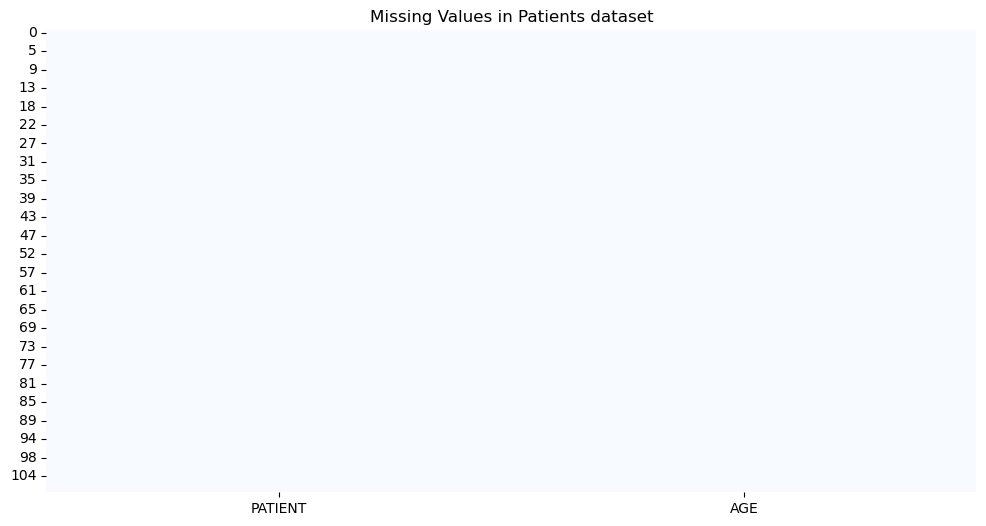

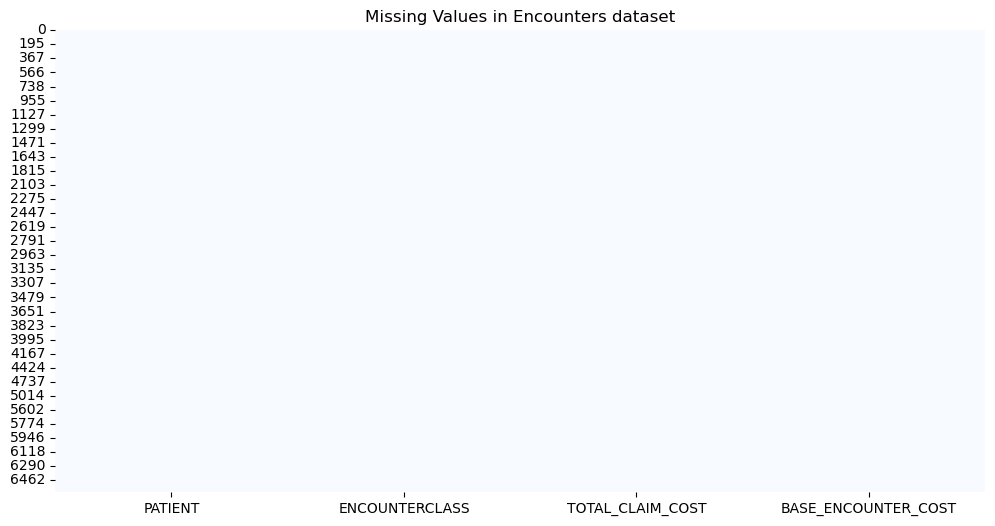

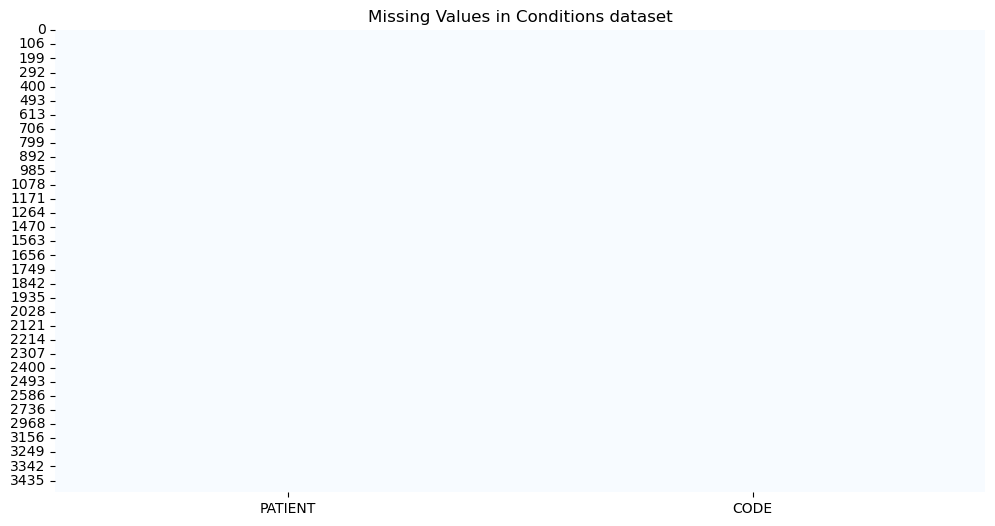

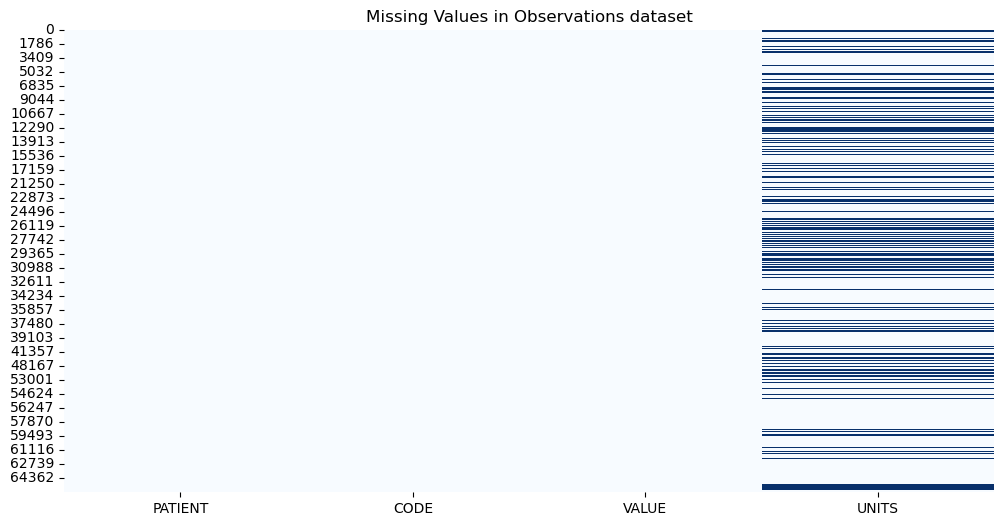

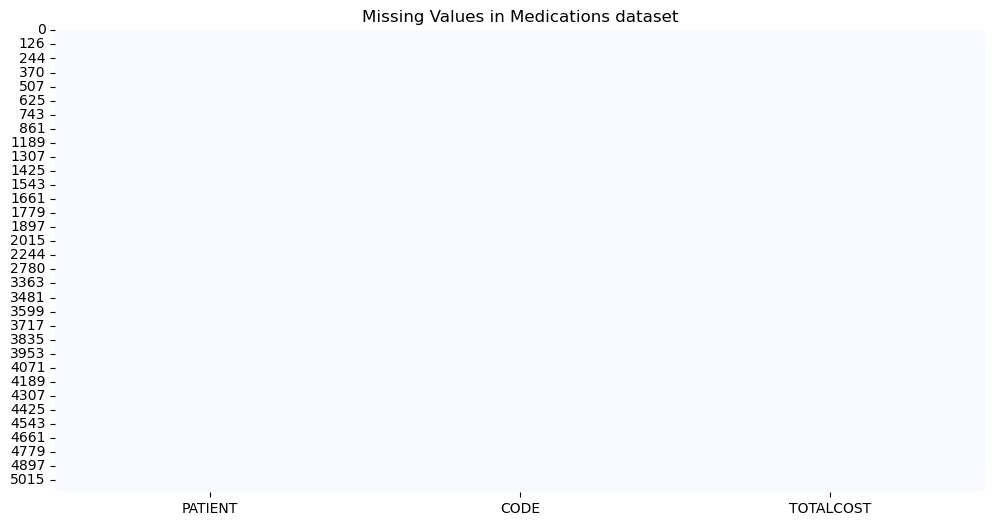

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Descriptive statistics for numerical columns (only relevant ones)
print("Descriptive Statistics for Patients dataset:")
print(patients[['AGE']].describe())  # Only AGE is relevant

print("\nDescriptive Statistics for Encounters dataset:")
print(encounters[['TOTAL_CLAIM_COST', 'BASE_ENCOUNTER_COST']].describe())  # Only cost-related columns

print("\nDescriptive Statistics for Medications dataset:")
print(medications[['TOTALCOST']].describe())  # Only TOTALCOST is relevant

# Step 2: Check for missing values in each dataset
print("\nMissing values in Patients dataset:")
print(patients.isnull().sum())

print("\nMissing values in Encounters dataset:")
print(encounters.isnull().sum())

print("\nMissing values in Conditions dataset:")
print(conditions.isnull().sum())  # Only 'CODE' matters, so missing check is useful

print("\nMissing values in Observations dataset:")
print(observations.isnull().sum())  # 'VALUE' and 'UNITS' are crucial

print("\nMissing values in Medications dataset:")
print(medications.isnull().sum())

# Step 3: Plot missing data heatmaps (only for datasets where it matters)
datasets = {
    "Patients": patients,
    "Encounters": encounters,
    "Conditions": conditions,
    "Observations": observations,
    "Medications": medications
}

for name, df in datasets.items():
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='Blues')
    plt.title(f'Missing Values in {name} dataset')
    plt.show()


We have missing values in only observations table so we have to handle them before moving forward.

In [47]:
# Step 1: Drop rows where 'CODE' (identifies vital signs/lab results) or 'VALUE' (numeric result) are missing
observations_cleaned = observations.dropna(subset=['CODE', 'VALUE'])

# Check the shape of the dataset before and after dropping missing 'CODE' or 'VALUE'
print(f"Shape of Observations dataset before cleaning: {observations.shape}")
print(f"Shape of Observations dataset after dropping missing 'CODE' or 'VALUE': {observations_cleaned.shape}")

# Step 2: Check for missing values in the 'UNITS' column
print("\nMissing values in 'UNITS' column after cleaning:")
print(observations_cleaned['UNITS'].isnull().sum())

# Step 3: Drop rows where 'UNITS' are missing (since it's needed for standardization)
observations_cleaned = observations_cleaned.dropna(subset=['UNITS'])

# Check the shape after removing rows with missing 'UNITS'
print(f"Shape of Observations dataset after dropping missing 'UNITS': {observations_cleaned.shape}")


Shape of Observations dataset before cleaning: (53549, 4)
Shape of Observations dataset after dropping missing 'CODE' or 'VALUE': (53549, 4)

Missing values in 'UNITS' column after cleaning:
15278
Shape of Observations dataset after dropping missing 'UNITS': (38271, 4)


In [49]:
import pandas as pd

# Step 1: Aggregate observations to get the number of unique observations per patient
observation_counts = observations.groupby('PATIENT').size().reset_index(name='num_observations')

# Step 2: Aggregate encounters to get total claim cost and base encounter cost per patient
encounter_totals = encounters.groupby('PATIENT').agg(
    total_claim_cost=('TOTAL_CLAIM_COST', 'sum'),
    total_base_encounter_cost=('BASE_ENCOUNTER_COST', 'sum')
).reset_index()

# Step 3: Aggregate conditions to get the number of unique conditions per patient
condition_counts = conditions.groupby('PATIENT').size().reset_index(name='num_conditions')

# Step 4: Aggregate medications to get the total medication cost per patient
medication_totals = medications.groupby('PATIENT').agg(
    total_medication_cost=('TOTALCOST', 'sum')
).reset_index()

# Step 5: Merge all the features into a single dataset
patient_features = patients.copy()

# Merge with encounters data
patient_features = patient_features.merge(encounter_totals, on='PATIENT', how='left')

# Merge with conditions data
patient_features = patient_features.merge(condition_counts, on='PATIENT', how='left')

# Merge with observations data
patient_features = patient_features.merge(observation_counts, on='PATIENT', how='left')

# Merge with medications data
patient_features = patient_features.merge(medication_totals, on='PATIENT', how='left')

# Fill missing values with 0 for aggregated numerical features
patient_features.fillna(0, inplace=True)

# Step 6: Save the processed feature dataset
patient_features.to_csv('patient_features.csv', index=False)

print("Final Processed Features Dataset Columns:")
print(patient_features.columns)


Final Processed Features Dataset Columns:
Index(['PATIENT', 'AGE', 'total_claim_cost', 'total_base_encounter_cost',
       'num_conditions', 'num_observations', 'total_medication_cost'],
      dtype='object')


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('patient_features.csv')

# Step 1: Summary Statistics
print("\n Basic Info:")
print(df.info())

print("\n Descriptive Statistics:")
print(df.describe())

# Step 2: Check for Missing Values
print("\n Missing Values:")
print(df.isnull().sum())


 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PATIENT                    100 non-null    object 
 1   AGE                        100 non-null    int64  
 2   total_claim_cost           100 non-null    float64
 3   total_base_encounter_cost  100 non-null    float64
 4   num_conditions             100 non-null    int64  
 5   num_observations           100 non-null    int64  
 6   total_medication_cost      100 non-null    float64
dtypes: float64(3), int64(3), object(1)
memory usage: 5.6+ KB
None

 Descriptive Statistics:
              AGE  total_claim_cost  total_base_encounter_cost  \
count  100.000000        100.000000                 100.000000   
mean    36.790000     130529.231000                6216.310100   
std     21.278953     164544.534753                8595.574603   
min      1.000000     

<Figure size 1200x800 with 0 Axes>

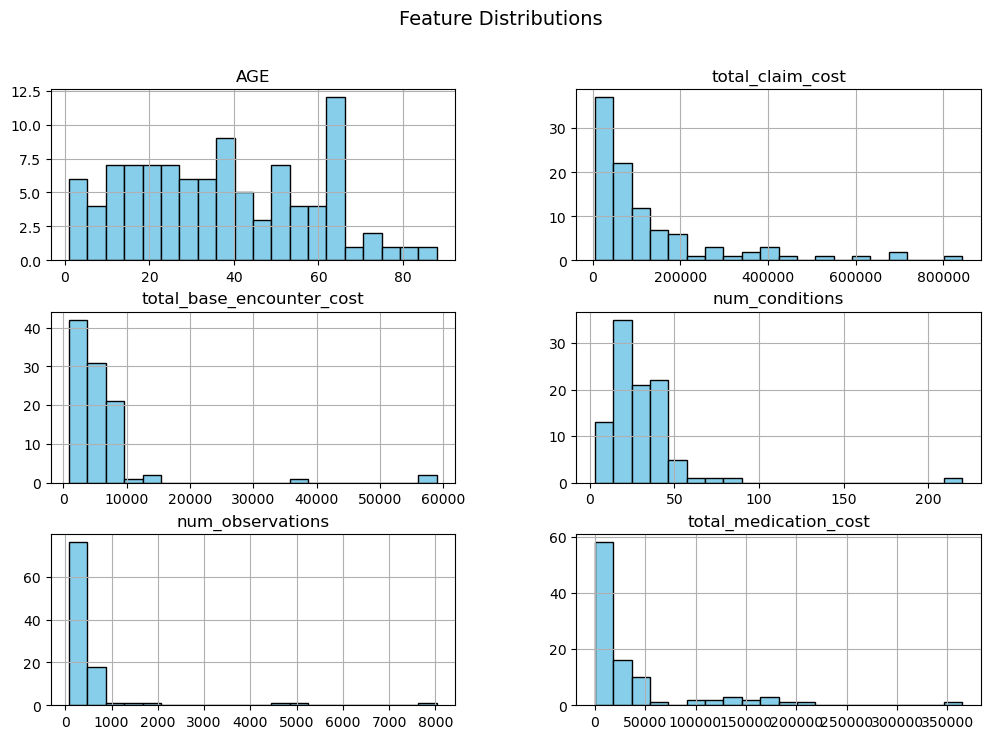

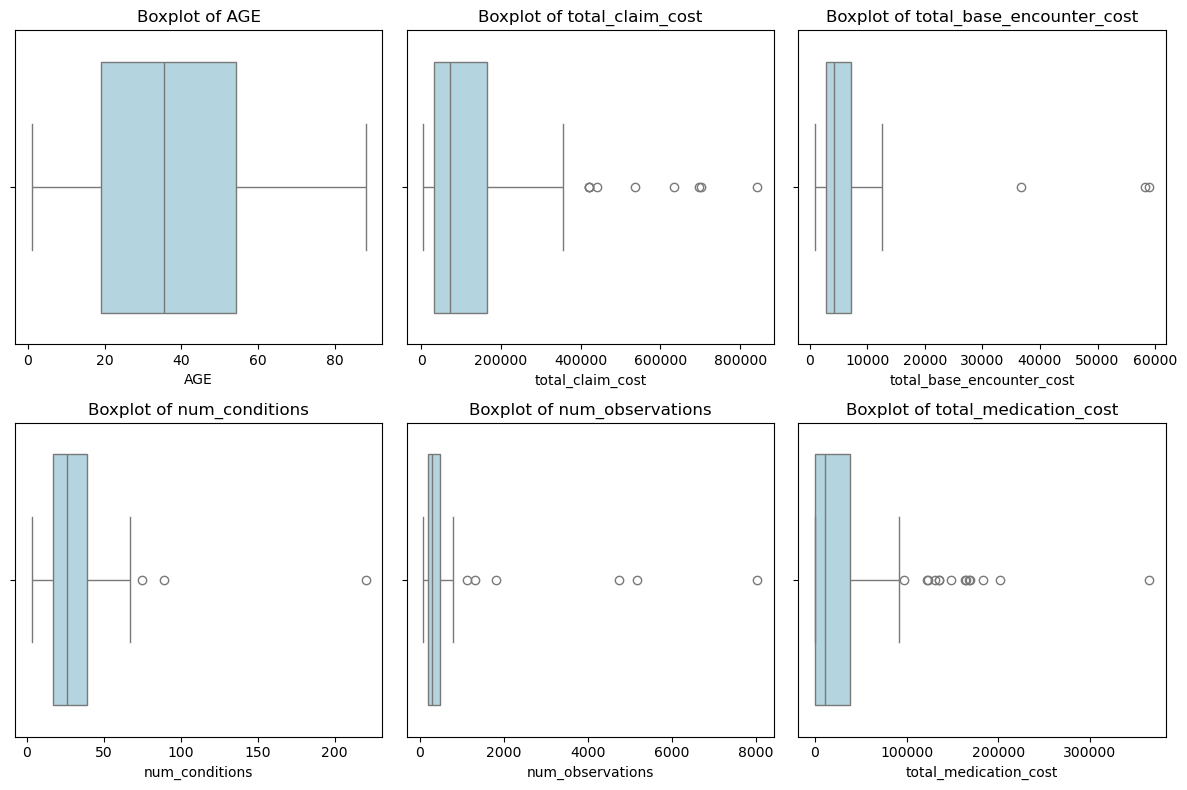

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define the numerical columns (strictly relevant to ICU risk scoring)
numerical_columns = ['AGE', 'total_claim_cost', 'total_base_encounter_cost', 
                     'num_conditions', 'num_observations', 'total_medication_cost']

# Step 2: Plot histograms for numerical features
plt.figure(figsize=(12, 8))
patient_features[numerical_columns].hist(figsize=(12, 8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=14)
plt.show()

# Step 3: Boxplots for numerical features (to check outliers)
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=patient_features[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [55]:
import numpy as np

# Function to remove outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile (25%)
    Q3 = df[column].quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1  # Interquartile Range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply IQR-based filtering to numerical columns
for col in ['total_claim_cost', 'total_base_encounter_cost', 'num_conditions', 
            'num_observations', 'total_medication_cost']:
    patient_features = remove_outliers_iqr(patient_features, col)

print("Shape after removing outliers:", patient_features.shape)


Shape after removing outliers: (75, 7)


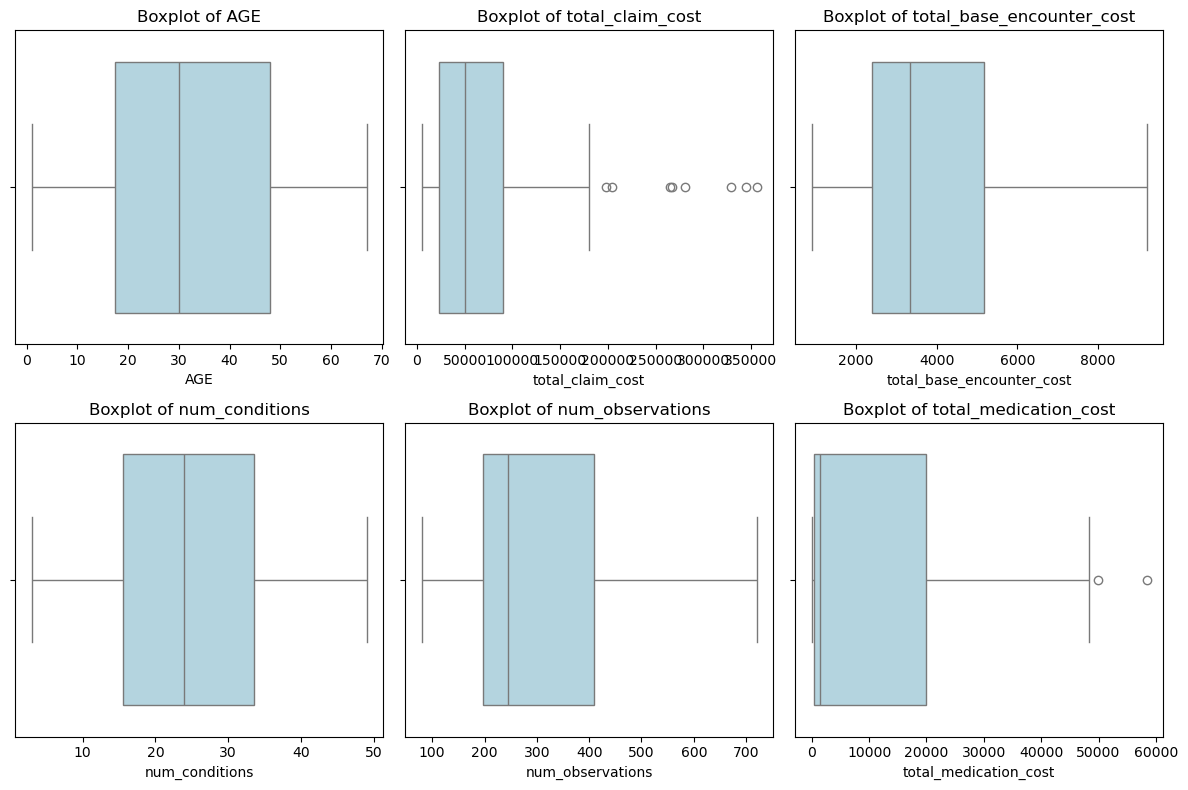

In [103]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=patient_features[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

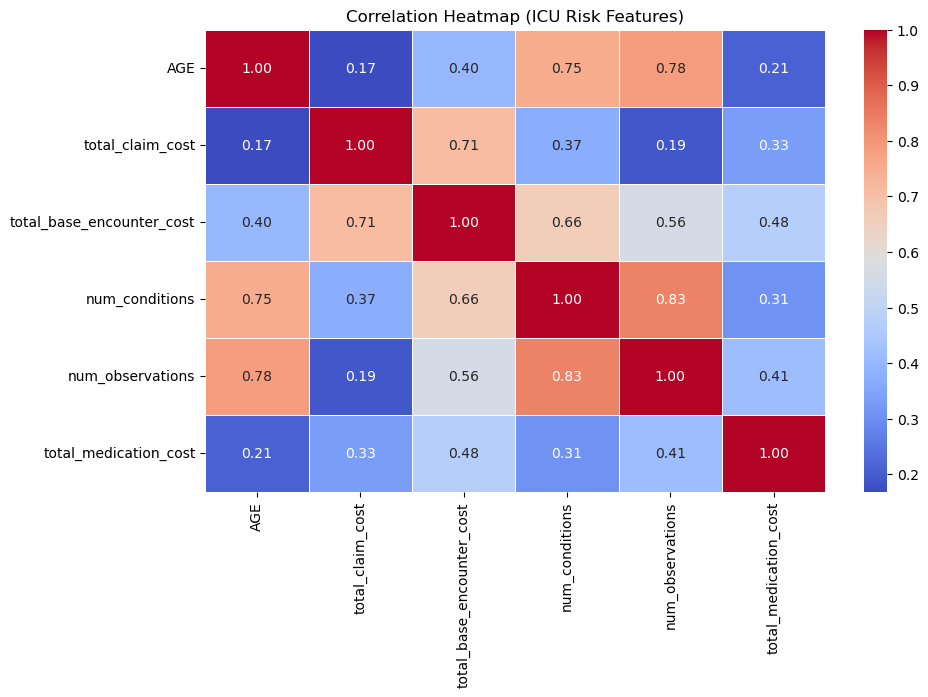

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Correlation Heatmap (only relevant numerical features)
plt.figure(figsize=(10, 6))
sns.heatmap(patient_features[['AGE', 'total_claim_cost', 'total_base_encounter_cost', 
                              'num_conditions', 'num_observations', 'total_medication_cost']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Heatmap (ICU Risk Features)')
plt.show()


In [61]:
print(patient_features.head())
print(patient_features.columns)

                                PATIENT  AGE  total_claim_cost  \
0  782c4f6e-4b08-ffba-af94-d6c1677ea363   40          14996.65   
1  3e953a04-3f6c-5d5f-4e6b-19ea23e75b6c   50         267733.33   
2  283414fa-9712-c6b3-81cd-394a795629b6   29          49941.68   
3  503ffe92-a8d8-3d20-21ab-f66fafccb467   55          77057.04   
4  ca16710a-8df6-c06c-9418-9d77266b0e6e   18          84486.56   

   total_base_encounter_cost  num_conditions  num_observations  \
0                    1626.45              16               196   
1                    8645.37              26               322   
2                    3219.37              35               464   
3                    5787.63              41               452   
4                    7556.31              21               333   

   total_medication_cost  
0                 175.80  
1                 419.85  
2               14134.63  
3               34953.43  
4               19032.39  
Index(['PATIENT', 'AGE', 'total_claim_cost',

In [63]:
import os
print(os.path.abspath("patient_features.csv"))  # This will show the exact location of the file

C:\Users\savas\Desktop\synthea-master\output\csv\patient_features.csv


In [67]:
import pandas as pd
try:
    df = pd.read_csv("patient_features.csv")
    print(" File loaded successfully!")
except Exception as e:
    print(f"🚨 Error: {e}")


 File loaded successfully!


In [69]:
import pandas as pd

# Load patient features dataset
file_path = "patient_features.csv"
patient_data = pd.read_csv(file_path)

# Assign clinically significant weights
weights = {
    "AGE": 0.15,
    "num_conditions": 0.20,
    "num_observations": 0.15,
    "total_medication_cost": 0.20,
    "total_claim_cost": 0.15,
    "total_base_encounter_cost": 0.15
}

# Normalize numerical features (Min-Max Scaling)
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Apply normalization only to available columns
for col in weights.keys():
    if col in patient_data.columns:  # Ensure the column exists before normalizing
        patient_data[col + "_SCORE"] = normalize(patient_data[col])

# Compute ICU Risk Score
patient_data["ICU_RISK_SCORE"] = sum(
    weights[col] * patient_data[col + "_SCORE"] for col in weights.keys() if col + "_SCORE" in patient_data.columns
)

# Classify patients into risk groups
def classify_risk(score):
    if score < 0.25:
        return "Low Risk"
    elif 0.25 <= score < 0.5:
        return "Medium Risk"
    else:
        return "High Risk"

patient_data["RISK_CATEGORY"] = patient_data["ICU_RISK_SCORE"].apply(classify_risk)

# Save classified dataset for Flask integration
classified_file_path = "icu_risk_classified.csv"
patient_data.to_csv(classified_file_path, index=False)

# Display output confirmation
print(" ICU Risk Classification Completed! Data saved as 'icu_risk_classified.csv'.")
print(patient_data[["PATIENT", "ICU_RISK_SCORE", "RISK_CATEGORY"]].head())


✅ ICU Risk Classification Completed! Data saved as 'icu_risk_classified.csv'.
                                PATIENT  ICU_RISK_SCORE RISK_CATEGORY
0  782c4f6e-4b08-ffba-af94-d6c1677ea363        0.085179      Low Risk
1  3e953a04-3f6c-5d5f-4e6b-19ea23e75b6c        0.177522      Low Risk
2  283414fa-9712-c6b3-81cd-394a795629b6        0.106808      Low Risk
3  503ffe92-a8d8-3d20-21ab-f66fafccb467        0.179844      Low Risk
4  ca16710a-8df6-c06c-9418-9d77266b0e6e        0.092544      Low Risk


In [153]:
print(patient_data[["PATIENT", "ICU_RISK_SCORE", "RISK_CATEGORY"]].describe())


       ICU_RISK_SCORE
count      100.000000
mean         0.151175
std          0.115258
min          0.001859
25%          0.075294
50%          0.139036
75%          0.186457
max          0.695159


C:\Users\savas\AppData\Local\Temp\ipykernel_22728\3957538664.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_distribution.index, y=risk_distribution.values, palette="Blues")


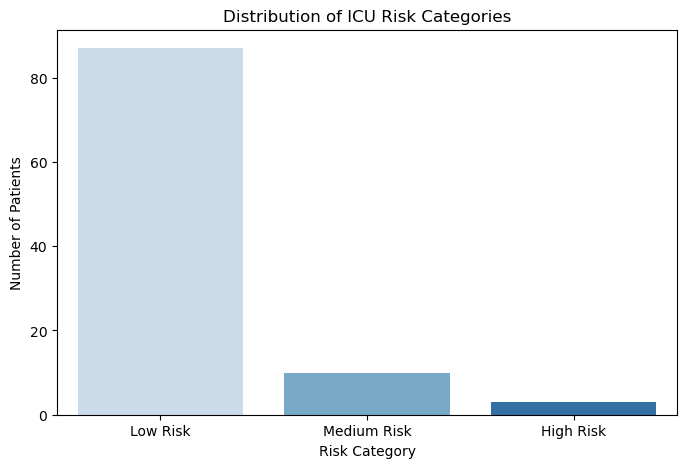

RISK_CATEGORY
Low Risk       87
Medium Risk    10
High Risk       3
Name: count, dtype: int64


In [155]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the distribution of risk categories
risk_distribution = patient_data["RISK_CATEGORY"].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=risk_distribution.index, y=risk_distribution.values, palette="Blues")
plt.title("Distribution of ICU Risk Categories")
plt.xlabel("Risk Category")
plt.ylabel("Number of Patients")
plt.show()

# Print exact counts
print(risk_distribution)


C:\Users\savas\AppData\Local\Temp\ipykernel_22728\4038837346.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_distribution_percentile.index, y=risk_distribution_percentile.values, palette="Reds")


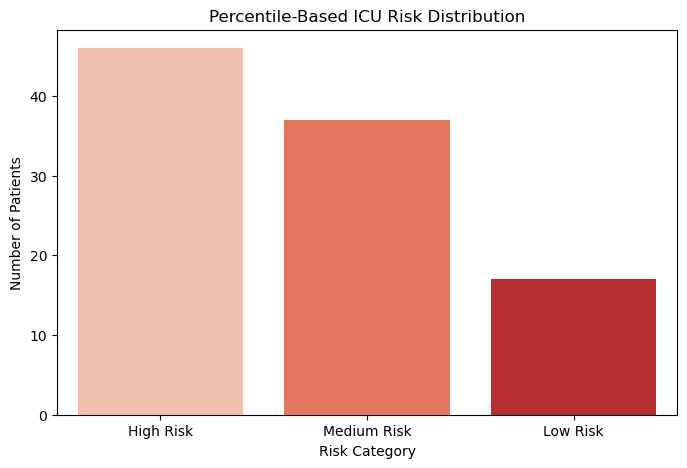

In [161]:
# Use percentile-based binning instead of strict normalization

def percentile_transform(series):
    return series.rank(pct=True)

# Apply percentile transformation to key features
for col in weights.keys():
    if col in patient_data.columns:
        patient_data[col + "_SCORE"] = percentile_transform(patient_data[col])

# Recalculate ICU Risk Score using percentile-adjusted features
patient_data["ICU_RISK_SCORE_PERCENTILE"] = sum(
    weights[col] * patient_data[col + "_SCORE"] for col in weights.keys() if col + "_SCORE" in patient_data.columns
)

# Reclassify risk categories
def classify_risk_percentile(score):
    if score < 0.25:
        return "Low Risk"
    elif 0.25 <= score < 0.55:
        return "Medium Risk"
    else:
        return "High Risk"

patient_data["RISK_CATEGORY_PERCENTILE"] = patient_data["ICU_RISK_SCORE_PERCENTILE"].apply(classify_risk_percentile)

# Plot new risk category distribution
risk_distribution_percentile = patient_data["RISK_CATEGORY_PERCENTILE"].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=risk_distribution_percentile.index, y=risk_distribution_percentile.values, palette="Reds")
plt.title("Percentile-Based ICU Risk Distribution")
plt.xlabel("Risk Category")
plt.ylabel("Number of Patients")
plt.show()

# Save percentile-adjusted classification results
final_percentile_file = "icu_risk_classified_percentile.csv"
patient_data.to_csv(final_percentile_file, index=False)
